In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [75]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [183]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, latent_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 128)
        self.fc2 = nn.Linear(128, 28*28)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [184]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, size_average=True):

        #dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)
 #          l1_reg = torch.FloatTensor(1)
#         self.E.fc2.weight.abs().sum(1)
#         mean_of_weights_on_one_neuron = self.E.fc2.weight.mean(1)
#         print(mean_of_weights_on_one_neuron.shape)
#         l1_reg = mean_of_weights_on_one_neuron.abs().sum()
        l1_reg = self.E.fc2.weight.abs().sum()
#         for W in self.E.fc2.weight:
#             l1_reg = l1_reg + W.norm(1)
#         print(self.E.fc2.weight.shape)
        
        self._rho_loss = l1_reg
    
#         if size_average:
#             self._rho_loss = l1_reg.mean()
#         else:
#             self._rho_loss = l1_reg.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [185]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [186]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            l1_loss = model.rho_loss()
            loss = model.loss(output, data) + l1_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [187]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss().item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [188]:
for epoch in range(1, 5):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.923896 32: 0.927654 64: 0.924128
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.312640 32: 0.288829 64: 0.280632
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.277082 32: 0.264645 64: 0.265761
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.258407 32: 0.249421 64: 0.249794
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.264843 32: 0.263829 64: 0.262131
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.295563 32: 0.296577 64: 0.294325
Test set:
16: loss: 0.2763	pho_loss: 0.0001
32: loss: 0.2773	pho_loss: 0.0000
64: loss: 0.2733	pho_loss: 0.0000

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.283718 32: 0.284496 64: 0.280976
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.287743 32: 0.287358 64: 0.286758
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.252301 32: 0.250689 64: 0.250331
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.267988 32: 0.267188 64: 0.267173
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.268048 32: 0.267790 64: 0.267709
Train

In [189]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = abs(models['64'].E(data.view(-1, 28*28)))
    print((encoded > 0.2).sum(1))
    encoded[encoded <  0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5])


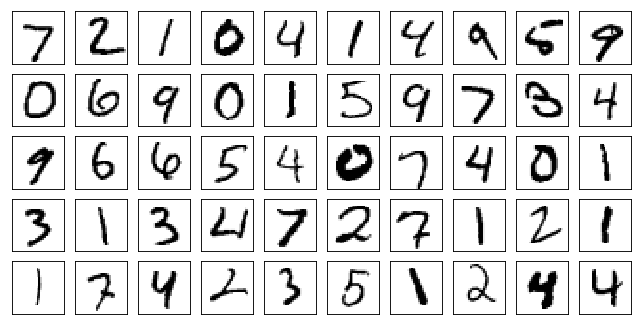

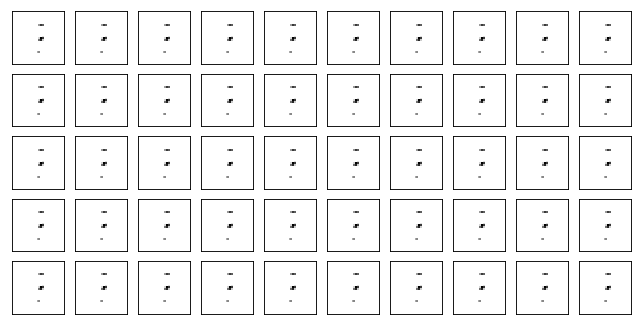

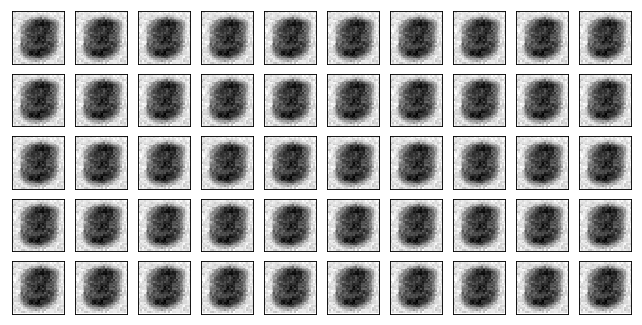

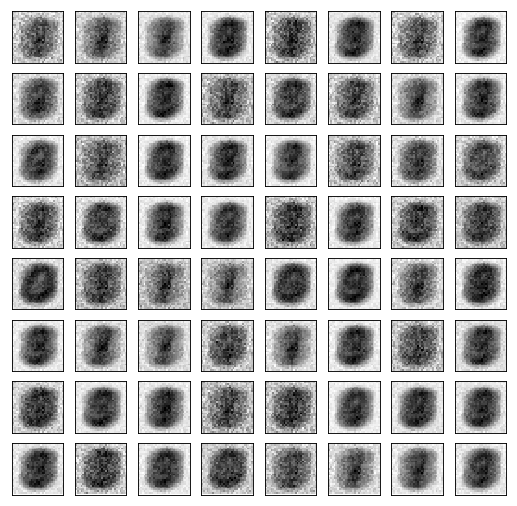

In [190]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))

In [17]:
l1_reg = torch.FloatTensor(1)

In [29]:
models['64'].E.fc2.parameters

<bound method Module.parameters of Linear(in_features=128, out_features=64, bias=True)>

In [39]:
for param in models['64'].E.fc2.parameters():
  print(param.data[0])

tensor([-0.0090, -0.0527,  0.0549,  0.0528, -0.0221,  0.0072, -0.0974,
         0.0193, -0.0587, -0.0709,  0.0175, -0.0434,  0.0415, -0.0561,
         0.0448,  0.0451, -0.0953, -0.0505,  0.0643,  0.0610,  0.0733,
        -0.0074, -0.0463, -0.0909,  0.0361, -0.0573, -0.0262, -0.0704,
        -0.0227, -0.0664,  0.0487, -0.0247, -0.0445, -0.0428, -0.0673,
        -0.0564, -0.0830, -0.0108, -0.0305,  0.0205, -0.1637,  0.0404,
         0.0014,  0.0141,  0.0584, -0.0387, -0.0675,  0.0283,  0.0482,
        -0.0617,  0.0782, -0.0925,  0.0016,  0.0721,  0.0637, -0.0856,
        -0.0160, -0.0682,  0.0422,  0.0595,  0.0244,  0.0596, -0.0496,
        -0.0856, -0.0817, -0.0974, -0.0015,  0.0505, -0.0760,  0.0404,
         0.0386, -0.0503, -0.0421,  0.0434, -0.0660, -0.0211, -0.0226,
         0.0545,  0.0765, -0.0656,  0.0266,  0.0651, -0.0450, -0.0895,
         0.0052, -0.0492,  0.0298, -0.0862, -0.0370, -0.0822, -0.0585,
         0.0653, -0.0206,  0.0348,  0.0350, -0.0481, -0.0560, -0.0980,
      

In [30]:
l1_reg = torch.FloatTensor(1)
for W in models['64'].E.fc2.parameters():
    l1_reg = l1_reg + W.norm(1)

In [31]:
l1_reg

tensor([ 383.2282])

In [92]:
l =  nn.Linear(3,5)
w = list(l.weight)

In [126]:
w[:][1].mean()

tensor(0.2896)

In [167]:
q = -1 * l.weight.mean(1)
q

tensor([-0.1427, -0.2896, -0.2969, -0.0612, -0.2284])

In [169]:

q.min().abs()

tensor(0.2969)

In [50]:
for param in models['64'].E.fc2.parameters():
  print(param.data[0,:])

tensor([-0.0090, -0.0527,  0.0549,  0.0528, -0.0221,  0.0072, -0.0974,
         0.0193, -0.0587, -0.0709,  0.0175, -0.0434,  0.0415, -0.0561,
         0.0448,  0.0451, -0.0953, -0.0505,  0.0643,  0.0610,  0.0733,
        -0.0074, -0.0463, -0.0909,  0.0361, -0.0573, -0.0262, -0.0704,
        -0.0227, -0.0664,  0.0487, -0.0247, -0.0445, -0.0428, -0.0673,
        -0.0564, -0.0830, -0.0108, -0.0305,  0.0205, -0.1637,  0.0404,
         0.0014,  0.0141,  0.0584, -0.0387, -0.0675,  0.0283,  0.0482,
        -0.0617,  0.0782, -0.0925,  0.0016,  0.0721,  0.0637, -0.0856,
        -0.0160, -0.0682,  0.0422,  0.0595,  0.0244,  0.0596, -0.0496,
        -0.0856, -0.0817, -0.0974, -0.0015,  0.0505, -0.0760,  0.0404,
         0.0386, -0.0503, -0.0421,  0.0434, -0.0660, -0.0211, -0.0226,
         0.0545,  0.0765, -0.0656,  0.0266,  0.0651, -0.0450, -0.0895,
         0.0052, -0.0492,  0.0298, -0.0862, -0.0370, -0.0822, -0.0585,
         0.0653, -0.0206,  0.0348,  0.0350, -0.0481, -0.0560, -0.0980,
      

IndexError: too many indices for tensor of dimension 1

In [42]:
for param in models['64'].E.fc2.parameters():
  print(param.data)

tensor([[-0.0090, -0.0527,  0.0549,  ..., -0.0937,  0.0395,  0.0271],
        [-0.0330, -0.0196, -0.0496,  ..., -0.0535,  0.0680, -0.0702],
        [ 0.0088, -0.0450, -0.0700,  ...,  0.0290,  0.0017, -0.0456],
        ...,
        [ 0.0575, -0.0198, -0.0640,  ...,  0.0020, -0.0273,  0.0197],
        [ 0.0566, -0.0043,  0.0357,  ..., -0.0181, -0.0552, -0.0280],
        [-0.0616, -0.1005,  0.0359,  ..., -0.0904,  0.0444,  0.0372]])
tensor(1.00000e-02 *
       [-9.7479,  4.6303, -5.4074, -1.8590,  6.3230, -8.0769, -0.2795,
        -8.1405, -9.4650,  6.8328,  6.0189,  1.7578,  1.7047,  2.5352,
         2.3848,  0.0529, -0.9390,  4.1027,  1.7096,  4.0704, -5.1529,
        -6.5372,  7.3037,  4.1695,  7.0132, -5.7605,  3.5351,  3.0043,
        -5.6950,  2.5351, -9.4666,  5.0812,  0.7771, -7.2812,  4.7791,
        -4.9564,  1.3770, -8.5274, -2.8881, -0.4547, -6.8416,  3.1538,
         4.2695,  1.4934,  1.1845,  6.1161, -9.3113, -2.3444,  4.1806,
        -9.2674, -6.1264, -8.7055,  2.6520, -3.7

In [48]:
models['64'].E.fc2.parameters.shape

AttributeError: 'function' object has no attribute 'shape'

In [49]:
models['64'].E.fc2.weight

Parameter containing:
tensor([[-0.0090, -0.0527,  0.0549,  ..., -0.0937,  0.0395,  0.0271],
        [-0.0330, -0.0196, -0.0496,  ..., -0.0535,  0.0680, -0.0702],
        [ 0.0088, -0.0450, -0.0700,  ...,  0.0290,  0.0017, -0.0456],
        ...,
        [ 0.0575, -0.0198, -0.0640,  ...,  0.0020, -0.0273,  0.0197],
        [ 0.0566, -0.0043,  0.0357,  ..., -0.0181, -0.0552, -0.0280],
        [-0.0616, -0.1005,  0.0359,  ..., -0.0904,  0.0444,  0.0372]])

In [182]:
models['64'].E.fc2.weight.shape

torch.Size([64, 128])

In [ ]:
E.fc2.weight